<a href="https://colab.research.google.com/github/shemaeric1234/Twitter-Sentiment-Analysis/blob/main/shema_Eric_221000428(Assignment_4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment details

- **Course Title**: Machine Learning and computational statistics DSC6232
- **Assignment Title**: Assignment 3

## Student Information
- **NAMES**: SHEMA ERIC
- **REG**: 221000428
- **COHORT**: 6
- **Specialization**: Data Science In Data Mining

# Twitter Sentiment Analysis

This notebook performs a complete sentiment analysis on Twitter data. It includes data collection (using a prepared dataset), preprocessing, EDA, feature engineering, model building, evaluation, hyperparameter tuning, and deployment preparation.

**Note:** For data collection, I use a prepared dataset from Kaggle

Sentiments are classified as positive, negative and neutral.

## 1. Import Libraries

In [ ]:
# -------------------------------
# Install required packages
# -------------------------------
!pip install --quiet nltk gensim wordcloud scikit-learn matplotlib seaborn tensorflow transformers torch

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

import gensim
from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from transformers import BertTokenizer, TFBertForSequenceClassification,BertModel
# from transformers import AdamW
from torch.optim import AdamW

import joblib
import pickle

import torch

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 2. Data Collection

In [ ]:
import pandas as pd

# Correct raw GitHub URL
df = pd.read_csv("/kaggle/input/twitter-tweets-sentiment-dataset/Tweets.csv", encoding="latin-1")

# Display info
print("Dataset Info:")
print(df.info())
print("\nSentiment Counts:")
print(df['sentiment'].value_counts())
df.head()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
None

Sentiment Counts:
sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


## 3. Data Preprocessing

Clean the text: remove links, emojis, stopwords, punctuation, handle hashtags, and convert to lowercase.

In [ ]:
import os
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Clear NLTK cache (force fresh download)
nltk.data.path = ['/root/nltk_data']
os.makedirs(nltk.data.path[0], exist_ok=True)


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Test if tokenization works
sample = "Hello world! This is a test."
tokens = word_tokenize(sample)
print(tokens)


# Define cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Drop only the 'selected_text' column
df = df.drop(columns=['selected_text'])

# Fit and transform sentiment column
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment_encoded'] = df['sentiment'].map(sentiment_mapping)

# Drop rows where sentiment or sentiment_encoded is NaN
df = df.dropna(subset=['sentiment', 'sentiment_encoded']).reset_index(drop=True)

# Apply cleaning
df['cleaned_text'] = df['text'].apply(clean_text)
df.head()



['Hello', 'world', '!', 'This', 'is', 'a', 'test', '.']


,textID,text,sentiment,sentiment_encoded,cleaned_text
0,cb774db0d1,"I`d have responded, if I were going",neutral,1,id responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,0,sooo sad miss san diego
2,088c60f138,my boss is bullying me...,negative,0,bos bullying
3,9642c003ef,what interview! leave me alone,negative,0,interview leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,0,son couldnt put release already bought


## 4. Exploratory Data Analysis (EDA)

Visualize word clouds, sentiment distribution, and class balance.

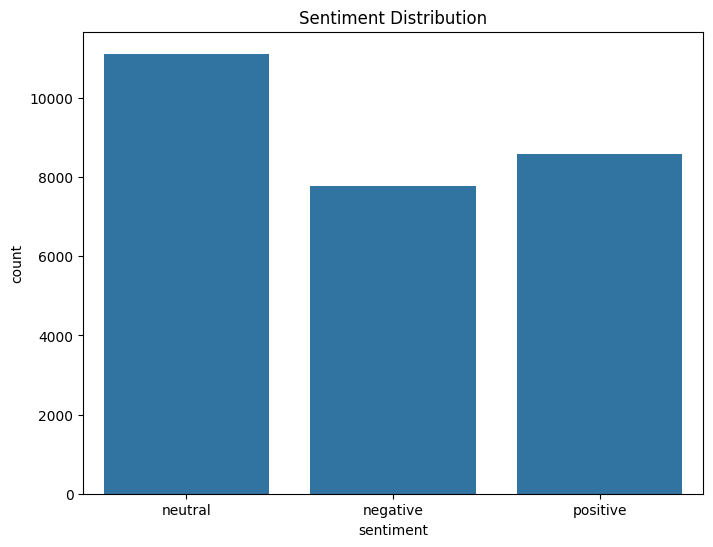

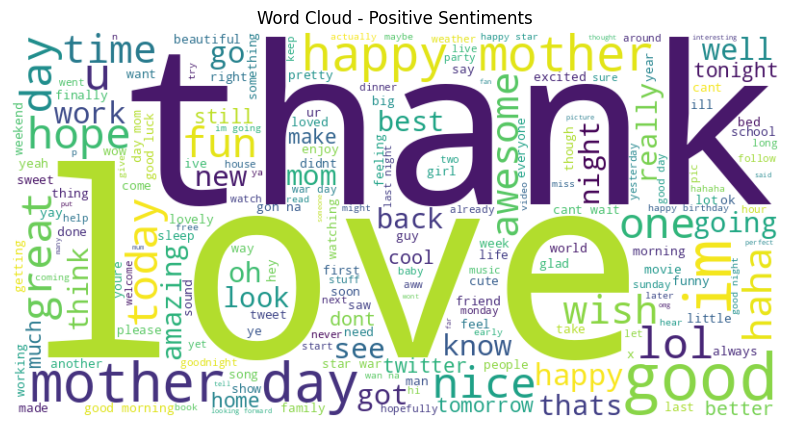

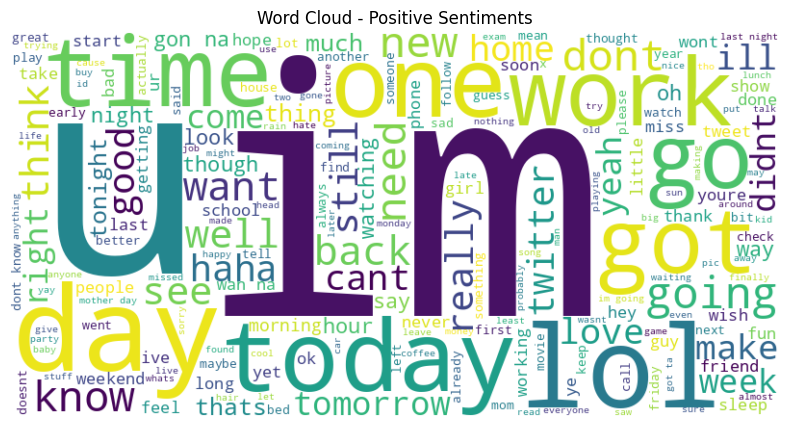

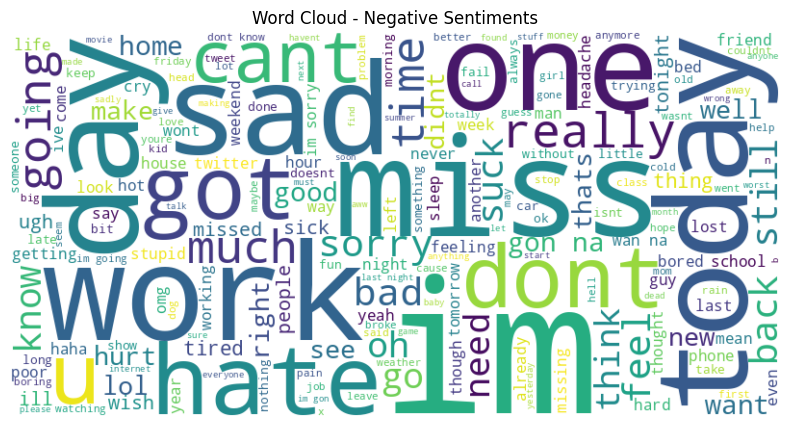

In [ ]:
# Sentiment distribution
plt.figure(figsize=(8,6))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

# Word cloud for positive sentiments
positive_text = ' '.join(df[df['sentiment'] == "positive"]['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Sentiments')
plt.show()

# Word cloud for neutral sentiments
positive_text = ' '.join(df[df['sentiment'] == "neutral"]['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Sentiments')
plt.show()

# Similarly for negative
negative_text = ' '.join(df[df['sentiment'] == "negative"]['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Negative Sentiments')
plt.show()

## 5. Feature Engineering

Compare Bag of Words, TF-IDF, Word2Vec, and BERT embeddings.

In [ ]:


# -------------------------------
# 1. Split data
# -------------------------------
X = df['cleaned_text']
y = df['sentiment_encoded']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# 2. Bag of Words
# -------------------------------
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# -------------------------------
# 3. TF-IDF
# -------------------------------
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# -------------------------------
# 4. Word2Vec Embeddings
# -------------------------------
tokenized_train = [word_tokenize(text) for text in X_train]
w2v_model = Word2Vec(
    sentences=tokenized_train, vector_size=100, window=5, min_count=1, workers=4
)

def get_w2v_embedding(text, vector_size=100):
    tokens = word_tokenize(text)
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)   # fallback for OOV or empty
    return np.mean(vectors, axis=0)

X_train_w2v = np.vstack([get_w2v_embedding(text) for text in X_train])
X_test_w2v = np.vstack([get_w2v_embedding(text) for text in X_test])

# -------------------------------
# 5. DistilBERT Embeddings (Batching for memory safety)
# -------------------------------
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm
import torch

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

def get_bert_embeddings_batch(texts, batch_size=16, max_length=128):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size].tolist()
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length
        )
        with torch.no_grad():
            outputs = bert_model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# ⚡ Use smaller subsets first to avoid memory crashes
X_train_bert = get_bert_embeddings_batch(X_train[:500], batch_size=16)
X_test_bert = get_bert_embeddings_batch(X_test[:200], batch_size=16)


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


## 6. Model Building

Train Logistic Regression (on TF-IDF), Random Forest (on TF-IDF), and LSTM (on embeddings).

In [ ]:
# -------------------------------
# 1. Logistic Regression on TF-IDF
# -------------------------------
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
lr_pred = lr_model.predict(X_test_tfidf)

# -------------------------------
# 2. Random Forest on TF-IDF
# -------------------------------
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
rf_pred = rf_model.predict(X_test_tfidf)

# -------------------------------
# 3. LSTM on padded sequences
# -------------------------------
# Tokenize text
tokenizer_seq = Tokenizer(num_words=5000)
tokenizer_seq.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer_seq.texts_to_sequences(X_train), maxlen=100)
X_test_seq = pad_sequences(tokenizer_seq.texts_to_sequences(X_test), maxlen=100)

# Determine number of output classes
num_classes = len(np.unique(y_train))

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=100))  # input_length optional
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(num_classes, activation='softmax'))

# Compile and train
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_seq, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Predict
lstm_pred_prob = lstm_model.predict(X_test_seq)
lstm_pred = np.argmax(lstm_pred_prob, axis=1)

Epoch 1/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 95s 332ms/step - accuracy: 0.5023 - loss: 0.9738 - val_accuracy: 0.6686 - val_loss: 0.7752
Epoch 2/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 140s 327ms/step - accuracy: 0.7265 - loss: 0.6710 - val_accuracy: 0.6841 - val_loss: 0.7512
Epoch 3/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 90s 328ms/step - accuracy: 0.7739 - loss: 0.5800 - val_accuracy: 0.6727 - val_loss: 0.7739
Epoch 4/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 141s 323ms/step - accuracy: 0.8023 - loss: 0.5290 - val_accuracy: 0.6780 - val_loss: 0.7986
Epoch 5/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 143s 327ms/step - accuracy: 0.8140 - loss: 0.4884 - val_accuracy: 0.6814 - val_loss: 0.8435
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step


## 7. Model Evaluation

Evaluate using accuracy, precision, recall, F1-score, confusion matrix, and ROC-AUC (for multi-class).

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

def evaluate_model(y_true, y_pred, model_name, y_pred_prob=None, le=None):
    print(f'\n{model_name} Evaluation:')
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred, average='weighted'))
    print('Recall:', recall_score(y_true, y_pred, average='weighted'))
    print('F1-Score:', f1_score(y_true, y_pred, average='weighted'))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix:\n', cm)

    # Optional: ROC-AUC if probabilities are provided
    if y_pred_prob is not None:
        try:
            roc_auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
            print('ROC-AUC Score:', roc_auc)
        except:
            print("ROC-AUC could not be computed (maybe binary/multi-class mismatch).")


# Logistic Regression
lr_pred_prob = lr_model.predict_proba(X_test_tfidf)
evaluate_model(y_test, lr_pred, 'Logistic Regression', y_pred_prob=lr_pred_prob, le=None)

# Random Forest
rf_pred_prob = rf_model.predict_proba(X_test_tfidf)
evaluate_model(y_test, rf_pred, 'Random Forest', y_pred_prob=rf_pred_prob, le=None)

# LSTM (already handled correctly)
evaluate_model(y_test, lstm_pred, 'LSTM', y_pred_prob=lstm_pred_prob, le=None)


Logistic Regression Evaluation:
Accuracy: 0.6931053301800982
Precision: 0.704788049545012
Recall: 0.6931053301800982
F1-Score: 0.6932861860417255
Confusion Matrix:
 [[ 936  543   77]
 [ 277 1698  249]
 [  64  477 1176]]
ROC-AUC Score: 0.8481640052887252

Random Forest Evaluation:
Accuracy: 0.7042022921593597
Precision: 0.7081534064136341
Recall: 0.7042022921593597
F1-Score: 0.7037250086182646
Confusion Matrix:
 [[ 956  498  102]
 [ 269 1634  321]
 [  75  361 1281]]
ROC-AUC Score: 0.8480035139149488

LSTM Evaluation:
Accuracy: 0.6891031471711843
Precision: 0.6929899448695872
Recall: 0.6891031471711843
F1-Score: 0.6886844526902299
Confusion Matrix:
 [[ 936  513  107]
 [ 298 1580  346]
 [  61  384 1272]]
ROC-AUC Score: 0.8347181450363976


## 8. Hyperparameter Tuning

Use GridSearchCV for Logistic Regression and Random Forest.

In [ ]:
# For Logistic Regression
param_grid_lr = {'C': [0.1, 1, 10]}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5)
grid_lr.fit(X_train_tfidf, y_train)
print('Best LR Params:', grid_lr.best_params_)
best_lr = grid_lr.best_estimator_

# For Random Forest
param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5)
grid_rf.fit(X_train_tfidf, y_train)
print('Best RF Params:', grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

Best LR Params: {'C': 1}
Best RF Params: {'max_depth': None, 'n_estimators': 100}


## 9. Deployment Preparation

Save the best model (e.g., tuned Logistic Regression) and show a simple prediction function. For API, use Flask example (run separately).

In [ ]:
# Save model and vectorizer
joblib.dump(best_lr, 'sentiment_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

# Load model and vectorizer
loaded_model = joblib.load('sentiment_model.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Optional: map encoded labels to text labels if needed
sentiment_map = {0:'negative', 1:'neutral',2:'positive'}

def predict_sentiment(text):
    cleaned = clean_text(text)
    vect = loaded_vectorizer.transform([cleaned])
    pred = loaded_model.predict(vect)[0]  # get the integer label
    # return integer directly:
    # return pred
    # OR return human-readable label:
    return sentiment_map.get(pred, pred)

# Exampled
print(predict_sentiment('I love this product'))  # Output: 'positive'


positive
